# Modlue 3. Distributed-Mutigpu Training with CutMix-ScriptMode
---

본 모듈에서는 Amzaon SageMaker API을 효과적으로 이용하기 위해 distributed-multigpu 학습을 위한 PyTorch 프레임워크 자체 구현만으로 모델 훈련을 수행해 봅니다.

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import os
import time, datetime

import warnings
warnings.filterwarnings('ignore')

from torch.utils.data import Dataset
from sklearn.metrics import recall_score

import matplotlib.pyplot as plt
import joblib

from sagemaker.pytorch import PyTorch, PyTorchModel

PyTorch 버전을 최신 버전으로 업데이트합니다. 

## 1. Setup

In [2]:
import time

import boto3
import glob
import numpy as np
from PIL import Image
import pandas as pd
import torch, torchvision
%config InlineBackend.figure_format = 'retina'
from matplotlib import pyplot as plt
from torchvision import datasets, transforms

import sagemaker
from sagemaker import get_execution_role
from sagemaker.session import Session

In [3]:
sess = boto3.Session()
sagemaker_session = sagemaker.Session()
sm = sess.client('sagemaker')
role = get_execution_role()

## 2. Upload dataset to S3 bucket

In [4]:
# create a s3 bucket to hold data, note that your account might already created a bucket with the same name
account_id = sess.client('sts').get_caller_identity()["Account"]
job_bucket = 'sagemaker-experiments-{}-{}'.format(sess.region_name, account_id)
data_bucket = 'sagemaker-{}-{}'.format(sess.region_name, account_id)
try:
    if sess.region_name == "us-east-1":
        sess.client('s3').create_bucket(Bucket=data_bucket)
    else:
        sess.client('s3').create_bucket(Bucket=data_bucket, 
                                        CreateBucketConfiguration={'LocationConstraint': sess.region_name})
except Exception as e:
    print(e)

An error occurred (BucketAlreadyOwnedByYou) when calling the CreateBucket operation: Your previous request to create the named bucket succeeded and you already own it.


In [5]:
local_data_paths = glob.glob('./input/train_image_data_*.parquet')
s3_data_path = sagemaker.s3_input(s3_data='s3://{}/{}'.format(data_bucket, 'bangali/train'), content_type='csv')

's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.


## 3. Write main_trainer.py

In [6]:
%%writefile ./src/requirements.txt
albumentations
pyarrow

Overwriting ./src/requirements.txt


In [7]:
%%writefile ./src/main_trainer.py

import argparse
import json
import logging
import os
import random
import sys
import time
import warnings
import glob
from functools import partial

import pandas as pd
import time, datetime
import gc

import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import recall_score
import logging.handlers

import matplotlib.pyplot as plt
import joblib

import numpy as np
import torch
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import torchvision.datasets as datasets
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

import dis_util
import sagemaker_containers
import util

## Apex import package
try:
    from apex.parallel import DistributedDataParallel as DDP
    from apex.fp16_utils import *
    from apex import amp, optimizers
    from apex.multi_tensor_apply import multi_tensor_applier
except ImportError:
    raise ImportError(
        "Please install apex from https://www.github.com/nvidia/apex to run this example.")


## augmentation for setting
from albumentations import (
    Rotate,HorizontalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, RandomBrightnessContrast, IAAPiecewiseAffine,
    IAASharpen, IAAEmboss, Flip, OneOf, Compose
)
from albumentations.pytorch import ToTensor, ToTensorV2

import dis_util
import sagemaker_containers
import util

logger = logging.getLogger(__name__)
logger.setLevel(logging.DEBUG)
logger.addHandler(logging.StreamHandler(sys.stdout))


def parser_args():
    parser = argparse.ArgumentParser()

    # Default Setting
    parser.add_argument('--log-interval', type=int, default=10, metavar='N',
                        help='how many batches to wait before logging training status')
    parser.add_argument('--backend', type=str, default='nccl',
                        help='backend for distributed training (tcp, gloo on cpu and gloo, nccl on gpu)')
    parser.add_argument('--channels-last', type=bool, default=True)
    parser.add_argument('--seed', type=int, default=1, metavar='S',
                        help='random seed (default: 1)')
    parser.add_argument('-p', '--print-freq', default=10, type=int,
                        metavar='N', help='print frequency (default: 10)')

    # Hyperparameter Setting
    parser.add_argument('--model_name', type=str, default='resnet50')
    parser.add_argument('--height', type=int, default=128)
    parser.add_argument('--width', type=int, default=128)
    parser.add_argument('--num_folds', type=int, default=5)
    parser.add_argument('--vld_fold_idx', type=int, default=4)
    parser.add_argument('--lr', type=float, default=0.001)
    parser.add_argument('--num_epochs', type=int, default=3)
    parser.add_argument('--batch-size', type=int, default=64)
    parser.add_argument('--test-batch-size', type=int, default=200, metavar='N',
                        help='input batch size for testing (default: 200)')

    # APEX Setting for Distributed Training
    parser.add_argument('--apex', type=bool, default=False)
    parser.add_argument('--opt-level', type=str, default='O0')
    parser.add_argument('--keep-batchnorm-fp32', type=str, default=None)
    parser.add_argument('--loss-scale', type=str, default=None)
    parser.add_argument('--sync_bn', action='store_true',
                        help='enabling apex sync BN.')
    parser.add_argument('--prof', default=-1, type=int,
                        help='Only run 10 iterations for profiling.')

    # SageMaker Container environment
    parser.add_argument('--hosts', type=list,
                        default=json.loads(os.environ['SM_HOSTS']))
    parser.add_argument('--current-host', type=str,
                        default=os.environ['SM_CURRENT_HOST'])
    parser.add_argument('--model-dir', type=str,
                        default=os.environ['SM_MODEL_DIR'])
    parser.add_argument('--data-dir', type=str,
                        default=os.environ['SM_CHANNEL_TRAINING'])
    parser.add_argument('--num-gpus', type=int,
                        default=os.environ['SM_NUM_GPUS'])
    parser.add_argument('--output_data_dir', type=str,
                        default=os.environ.get('SM_OUTPUT_DATA_DIR'))

    args = parser.parse_args()
    return args

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.model = models.resnet18(pretrained=True)
        last_hidden_units = self.model.fc.out_features
        self.classifer_model = nn.Linear(last_hidden_units, 186)
    @staticmethod
    def forward(self, x):
        with torch.no_grad():
            features = self.model(x)
        x = self.classifer_model(features)
        return x
    
    
class BangaliDataset(Dataset):
    def __init__(self, imgs, label_df=None, transform=None):
        self.imgs = imgs
        self.label_df = label_df.reset_index(drop=True)
        self.transform = transform
        
    def __len__(self):
        return len(self.label_df)
    
    def __getitem__(self, idx):
        
        img_idx = self.label_df.iloc[idx].id
        img = (self.imgs[img_idx]).astype(np.uint8)
        img = 255 - img
    
        img = img[:,:,np.newaxis]
        img = np.repeat(img, 3, axis=2)
        
        if self.transform is not None:
            img = self.transform(image=img)['image']        
        
        if self.label_df is not None:
            label_1 = self.label_df.iloc[idx].grapheme_root
            label_2 = self.label_df.iloc[idx].vowel_diacritic
            label_3 = self.label_df.iloc[idx].consonant_diacritic           
            return img, np.array([label_1, label_2, label_3])        
        else:
            return img
        
        

def _rand_bbox(size, lam):
    '''
    CutMix Helper function.
    Retrieved from https://github.com/clovaai/CutMix-PyTorch/blob/master/train.py
    '''
    W = size[2]
    H = size[3]
    # 폭과 높이는 주어진 이미지의 폭과 높이의 beta distribution에서 뽑은 lambda로 얻는다
    cut_rat = np.sqrt(1. - lam)
    
    # patch size 의 w, h 는 original image 의 w,h 에 np.sqrt(1-lambda) 를 곱해준 값입니다.
    cut_w = np.int(W * cut_rat)
    cut_h = np.int(H * cut_rat)

    # patch의 중심점은 uniform하게 뽑힘
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    return bbx1, bby1, bbx2, bby2


def _set_seed(seed=42):
    np.random.seed(seed)
    random.seed(seed)
    mx.random.seed(seed)

def _get_images(args, data_type='train'):

    logger.info("=== Getting Labels ===")
    logger.info(args.data_dir)
    
    label_df = pd.read_csv(os.path.join(args.data_dir, 'train_folds.csv'))
     
    trn_fold = [i for i in range(args.num_folds) if i not in [args.vld_fold_idx]]
    vld_fold = [args.vld_fold_idx]

    trn_idx = label_df.loc[label_df['fold'].isin(trn_fold)].index
    vld_idx = label_df.loc[label_df['fold'].isin(vld_fold)].index

    logger.info("=== Getting Images ===")
    files = [file for file in glob.glob(os.path.join(args.data_dir,'*')) if file.split('.')[-1] == 'parquet']
#     files = [f'{args.data_dir}/{data_type}_image_data_{i}.parquet' for i in range(4)]
    logger.info(files)
    
    image_df_list = [pd.read_parquet(f) for f in files]
    imgs = [df.iloc[:, 1:].values.reshape(-1, args.height, args.width) for df in image_df_list]
    del image_df_list
    gc.collect()
    args.imgs = np.concatenate(imgs, axis=0)
    
    args.trn_df = label_df.loc[trn_idx]
    args.vld_df = label_df.loc[vld_idx]
    

    
    return args 


def _get_train_data_loader(args, **kwargs):
    logger.info("Get train data loader")
    train_transforms = Compose([
        Rotate(20),
            OneOf([
                IAAAdditiveGaussianNoise(),
                GaussNoise(),
            ], p=0.2),
            OneOf([
                MotionBlur(p=.2),
                MedianBlur(blur_limit=3, p=0.1),
                Blur(blur_limit=3, p=0.1),
            ], p=0.2),
            ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=45, p=0.2),
            OneOf([
                OpticalDistortion(p=0.3),
                GridDistortion(p=.1),
                IAAPiecewiseAffine(p=0.3),
            ], p=0.2),
            OneOf([
                CLAHE(clip_limit=2),
                IAASharpen(),
                IAAEmboss(),
                RandomBrightnessContrast(),            
            ], p=0.3),
            HueSaturationValue(p=0.3),
#         ToTensor()
        ], p=1.0)
    
    dataset = BangaliDataset(imgs=args.imgs, label_df=args.trn_df, transform=train_transforms)
    train_sampler = data.distributed.DistributedSampler(
        dataset, num_replicas=int(args.world_size), rank=int(args.rank)) if args.multigpus_distributed else None
    return data.DataLoader(dataset, batch_size=args.batch_size, shuffle=train_sampler is None,
                                       sampler=train_sampler, collate_fn=dis_util.fast_collate, **kwargs), train_sampler


def _get_test_data_loader(args, **kwargs):
    logger.info("Get test data loader")   

    dataset = BangaliDataset(imgs=args.imgs, label_df=args.vld_df)
    val_sampler = data.distributed.DistributedSampler(dataset) if args.multigpus_distributed else None
    return data.DataLoader(dataset, batch_size=args.test_batch_size, shuffle=False, 
                           sampler=val_sampler, collate_fn=dis_util.fast_collate, **kwargs)


def train(current_gpu, args):
    best_acc1 = -1
    model_history = {}
    model_history = util.init_modelhistory(model_history)
    train_start = time.time()

    ## choose model from pytorch model_zoo
    model = util.torch_model(args.model_name, pretrained=True)
    loss_fn = nn.CrossEntropyLoss().cuda()

    ## distributed_setting 
    model, args = dis_util.dist_setting(current_gpu, model, loss_fn, args)

    ## CuDNN library will benchmark several algorithms and pick that which it found to be fastest
    cudnn.benchmark = False if args.seed else True

    optimizer = optim.Adam(model.parameters(), lr=args.lr)

    if args.apex:
        model, optimizer = dis_util.apex_init(model, optimizer, args)
    
    
#     args.collate_fn = partial(dis_util.fast_collate, memory_format=args.memory_format)
   
    args = _get_images(args, data_type='train')
    train_loader, train_sampler = _get_train_data_loader(args, **args.kwargs)
    test_loader = _get_test_data_loader(args, **args.kwargs)

    logger.info("Processes {}/{} ({:.0f}%) of train data".format(
        len(train_loader.sampler), len(train_loader.dataset),
        100. * len(train_loader.sampler) / len(train_loader.dataset)
    ))

    logger.info("Processes {}/{} ({:.0f}%) of test data".format(
        len(test_loader.sampler), len(test_loader.dataset),
        100. * len(test_loader.sampler) / len(test_loader.dataset)
    ))

    for epoch in range(1, args.num_epochs + 1):
        ## 
        batch_time = util.AverageMeter('Time', ':6.3f')
        data_time = util.AverageMeter('Data', ':6.3f')
        losses = util.AverageMeter('Loss', ':.4e')
        top1 = util.AverageMeter('Acc@1', ':6.2f')
        top5 = util.AverageMeter('Acc@5', ':6.2f')
        progress = util.ProgressMeter(
            len(train_loader),
            [batch_time, data_time, losses, top1, top5],
            prefix="Epoch: [{}]".format(epoch))
        
        trn_loss = []
        model.train()
        end = time.time()
        running_loss = 0.0
        ## Set epoch count for DistributedSampler
        if args.multigpus_distributed:
            train_sampler.set_epoch(epoch)
        
        
        prefetcher = util.data_prefetcher(train_loader)
        input, target = prefetcher.next()
        batch_idx = 0
        while input is not None:

            batch_idx += 1
            
            if args.prof >= 0 and batch_idx == args.prof:
                print("Profiling begun at iteration {}".format(batch_idx))
                torch.cuda.cudart().cudaProfilerStart()
                
            if args.prof >= 0: torch.cuda.nvtx.range_push("Body of iteration {}".format(batch_idx))

            util.adjust_learning_rate(optimizer, epoch, batch_idx, len(train_loader), args)
            
            ##### DATA Processing #####
            targets_gra = target[:, 0]
            targets_vow = target[:, 1]
            targets_con = target[:, 2]

            # 50%의 확률로 원본 데이터 그대로 사용    
            if np.random.rand() < 0.5:
                logits = model(input)
                grapheme = logits[:, :168]
                vowel = logits[:, 168:179]
                cons = logits[:, 179:]

                loss1 = loss_fn(grapheme, targets_gra)
                loss2 = loss_fn(vowel, targets_vow)
                loss3 = loss_fn(cons, targets_con) 

            else:

                lam = np.random.beta(1.0, 1.0) 
                rand_index = torch.randperm(input.size()[0])
                shuffled_targets_gra = targets_gra[rand_index]
                shuffled_targets_vow = targets_vow[rand_index]
                shuffled_targets_con = targets_con[rand_index]

                bbx1, bby1, bbx2, bby2 = _rand_bbox(input.size(), lam)
                input[:, :, bbx1:bbx2, bby1:bby2] = input[rand_index, :, bbx1:bbx2, bby1:bby2]
                # 픽셀 비율과 정확히 일치하도록 lambda 파라메터 조정  
                lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (input.size()[-1] * input.size()[-2]))
                
                logits = model(input)
                grapheme = logits[:,:168]
                vowel = logits[:, 168:179]
                cons = logits[:, 179:]

                loss1 = loss_fn(grapheme, targets_gra) * lam + loss_fn(grapheme, shuffled_targets_gra) * (1. - lam)
                loss2 = loss_fn(vowel, targets_vow) * lam + loss_fn(vowel, shuffled_targets_vow) * (1. - lam)
                loss3 = loss_fn(cons, targets_con) * lam + loss_fn(cons, shuffled_targets_con) * (1. - lam)

            loss = 0.5 * loss1 + 0.25 * loss2 + 0.25 * loss3    
            trn_loss.append(loss.item())
            running_loss += loss.item()
            
            #########################################################

            # compute gradient and do SGD step
            optimizer.zero_grad()
            
            if args.apex:
                with amp.scale_loss(loss, optimizer) as scaled_loss:
                    scaled_loss.backward()
            else:
                loss.backward()

            optimizer.step()
            # Printing vital information
            if (batch_idx + 1) % (args.log_interval) == 0:
                s = f'[Epoch {epoch} Batch {batch_idx+1}/{len(train_loader)}] ' \
                f'loss: {running_loss / args.log_interval:.4f}'
                print(s)
                running_loss = 0
                
                
            if True or batch_idx % args.log_interval == 0:
                # Every log_interval iterations, check the loss, accuracy, and speed.
                # For best performance, it doesn't make sense to print these metrics every
                # iteration, since they incur an allreduce and some host<->device syncs.

                # Measure accuracy
                prec1, prec5 = util.accuracy(logits, target, topk=(1, 5))

                # Average loss and accuracy across processes for logging
                if args.multigpus_distributed:
                    reduced_loss = dis_util.reduce_tensor(loss.data, args)
                    prec1 = dis_util.reduce_tensor(prec1, args)
                    prec5 = dis_util.reduce_tensor(prec5, args)
                else:
                    reduced_loss = loss.data
                
                # to_python_float incurs a host<->device sync
                losses.update(to_python_float(reduced_loss), input.size(0))
                top1.update(to_python_float(prec1), input.size(0))
                top5.update(to_python_float(prec5), input.size(0))
                
                ## Waiting until finishing operations on GPU (Pytorch default: async)
                torch.cuda.synchronize()
                batch_time.update((time.time() - end)/args.log_interval)
                end = time.time()

                if current_gpu == 0:
                    print('Epoch: [{0}][{1}/{2}]  '
                          'Time {batch_time.val:.3f} ({batch_time.avg:.3f})  '
                          'Speed {3:.3f} ({4:.3f})  '
                          'Loss {loss.val:.10f} ({loss.avg:.4f})  '
                          'Prec@1 {top1.val:.3f} ({top1.avg:.3f})  '
                          'Prec@5 {top5.val:.3f} ({top5.avg:.3f})'.format(
                              epoch, batch_idx, len(train_loader),
                              args.world_size*args.batch_size/batch_time.val,
                              args.world_size*args.batch_size/batch_time.avg,
                              batch_time=batch_time,
                              loss=losses, top1=top1, top5=top5))
                    model_history['epoch'].append(epoch)
                    model_history['batch_idx'].append(batch_idx)
                    model_history['batch_time'].append(batch_time.val)
                    model_history['losses'].append(losses.val)
                    model_history['top1'].append(top1.val)
                    model_history['top5'].append(top5.val)
                    

            input, target = prefetcher.next()
            
        acc1 = validate(test_loader, model, loss_fn, epoch, model_history, trn_loss, args)            

        # remember best acc@1 and save checkpoint
        is_best = acc1 > best_acc1
        best_acc1 = max(acc1, best_acc1)


        if not args.multigpus_distributed or (args.multigpus_distributed and args.rank % args.num_gpus == 0):
            util.save_history(os.path.join(args.output_data_dir,
                          'model_history.p'), model_history)

            util.save_model({
                'epoch': epoch + 1,
                'model_name': args.model_name,
                'state_dict': model.state_dict(),
                'best_acc1': best_acc1,
                'optimizer': optimizer.state_dict(),
#                 'class_to_idx' : train_loader.dataset.class_to_idx,
            }, is_best, args.model_dir)


def validate(val_loader, model, loss_fn, epoch, model_history, trn_loss, args):
    batch_time = util.AverageMeter('Time', ':6.3f')
    losses = util.AverageMeter('Loss', ':.4e')
    top1 = util.AverageMeter('Acc@1', ':6.2f')
    top5 = util.AverageMeter('Acc@5', ':6.2f')
    progress = util.ProgressMeter(
        len(val_loader),
        [batch_time, losses, top1, top5],
        prefix='Test: ')
    val_loss = []
    val_true = []
    val_pred = []
    
    # switch to evaluate mode
    model.eval()
    end = time.time()

    prefetcher = util.data_prefetcher(val_loader)
    input, target = prefetcher.next()
    batch_idx = 0
    while input is not None:
        batch_idx += 1
    
        # compute output
        with torch.no_grad():
                logits = model(input)
                grapheme = logits[:,:168]
                vowel = logits[:, 168:179]
                cons = logits[:, 179:]

                loss= 0.5* loss_fn(grapheme, target[:,0]) + 0.25*loss_fn(vowel, target[:,1]) + \
                0.25*loss_fn(vowel, target[:,2])
                val_loss.append(loss.item())

                grapheme = grapheme.cpu().argmax(dim=1).data.numpy()
                vowel = vowel.cpu().argmax(dim=1).data.numpy()
                cons = cons.cpu().argmax(dim=1).data.numpy()

                val_true.append(target.cpu().numpy())
                val_pred.append(np.stack([grapheme, vowel, cons], axis=1))                
  
                
        # measure accuracy and record loss
        prec1, prec5 = util.accuracy(logits, target, topk=(1, 5))

        if args.multigpus_distributed:
            reduced_loss = dis_util.reduce_tensor(loss.data, args)
            prec1 = dis_util.reduce_tensor(prec1, args)
            prec5 = dis_util.reduce_tensor(prec5, args)
        else:
            reduced_loss = loss.data

        losses.update(to_python_float(reduced_loss), input.size(0))
        top1.update(to_python_float(prec1), input.size(0))
        top5.update(to_python_float(prec5), input.size(0))

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        # TODO:  Change timings to mirror train().
        if args.current_gpu == 0 and batch_idx % args.log_interval == 0:
            print('Test: [{0}/{1}]  '
                  'Time {batch_time.val:.3f} ({batch_time.avg:.3f})  '
                  'Speed {2:.3f} ({3:.3f})  '
                  'Loss {loss.val:.4f} ({loss.avg:.4f})  '
                  'Prec@1 {top1.val:.3f} ({top1.avg:.3f})  '
                  'Prec@5 {top5.val:.3f} ({top5.avg:.3f})'.format(
                      batch_idx, len(val_loader),
                      args.world_size * args.batch_size / batch_time.val,
                      args.world_size * args.batch_size / batch_time.avg,
                      batch_time=batch_time, loss=losses,
                      top1=top1, top5=top5))
            model_history['val_epoch'].append(epoch)
            model_history['val_batch_idx'].append(batch_idx)
            model_history['val_batch_time'].append(batch_time.val)
            model_history['val_losses'].append(losses.val)
            model_history['val_top1'].append(top1.val)
            model_history['val_top5'].append(top5.val)
        input, target = prefetcher.next()


        
    val_true_concat = np.concatenate(val_true)
    val_pred_concat = np.concatenate(val_pred)
    val_loss_mean = np.mean(val_loss)
    trn_loss_mean = np.mean(trn_loss)

    score_g = recall_score(val_true_concat[:,0], val_pred_concat[:,0], average='macro')
    score_v = recall_score(val_true_concat[:,1], val_pred_concat[:,1], average='macro')
    score_c = recall_score(val_true_concat[:,2], val_pred_concat[:,2], average='macro')
    final_score = np.average([score_g, score_v, score_c], weights=[2,1,1])

    if args.current_gpu == 0:
        # Printing vital information
        s = f'[Epoch {epoch}] ' \
        f'trn_loss: {trn_loss_mean:.4f}, vld_loss: {val_loss_mean:.4f}, score: {final_score:.4f}, ' \
        f'score_each: [{score_g:.4f}, {score_v:.4f}, {score_c:.4f}]'          
        print(s)  
        
        
    print('  Prec@1 {top1.avg:.3f} Prec@5 {top5.avg:.3f}'.format(top1=top1, top5=top5))
    model_history['val_avg_epoch'].append(epoch)
    model_history['val_avg_batch_time'].append(batch_time.avg)
    model_history['val_avg_losses'].append(losses.avg)
    model_history['val_avg_top1'].append(top1.avg)
    model_history['val_avg_top5'].append(top5.avg)
    return top1.avg

## iter() overflowerror: cannot serialize a bytes object larger than 4 gib --> num_worker=0 resolved
def main():
    args = parser_args()
    args.use_cuda = args.num_gpus > 0
    print("args.use_cuda : {} , args.num_gpus : {}".format(
        args.use_cuda, args.num_gpus))
    args.kwargs = {'num_workers': 0,
                   'pin_memory': True} if args.use_cuda else {}
    args.device = torch.device("cuda" if args.use_cuda else "cpu")
    dis_util.dist_init(train, args)


if __name__ == '__main__':
    main()


Overwriting ./src/main_trainer.py


In [8]:
%%writefile ./src/dis_util.py

import argparse
import logging
import numpy as np
import os
import random
import sys
import warnings

import torch
import torch.backends.cudnn as cudnn
import torch.distributed as dist
import torch.multiprocessing as mp
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data.distributed

import sagemaker_containers

try:
    from apex.parallel import DistributedDataParallel as DDP
    from apex.fp16_utils import *
    from apex import amp, optimizers
    from apex.multi_tensor_apply import multi_tensor_applier
except ImportError:
    raise ImportError(
        "Please install apex from https://www.github.com/nvidia/apex to run this example.")


logger = logging.getLogger(__name__)
logger.setLevel(logging.DEBUG)
logger.addHandler(logging.StreamHandler(sys.stdout))


def dist_init(fn, args):
    if args.seed is not None:
        random.seed(args.seed)
        torch.manual_seed(args.seed)
        cudnn.deterministic = True
        warnings.warn('You have chosen to seed training. '
                      'This will turn on the CUDNN deterministic setting, '
                      'which can slow down your training considerably! '
                      'You may see unexpected behavior when restarting '
                      'from checkpoints.')

    args.is_distributed = len(args.hosts) > 1 and args.backend is not None
    args.is_multigpus = args.num_gpus > 1
    args.multigpus_distributed = (args.is_distributed or args.is_multigpus)

    logger.debug("Distributed training - {}".format(args.is_distributed))
    logger.debug("Number of gpus available - {}".format(args.num_gpus))

    args.world_size = 1
    if args.multigpus_distributed:
        # Initialize the distributed environment.
        args.apex = True
        args.world_size = len(args.hosts) * args.num_gpus
        os.environ['WORLD_SIZE'] = str(args.world_size)
        args.host_num = args.hosts.index(args.current_host)
        mp.spawn(fn, nprocs=args.num_gpus, args=(args,))
    else:
        current_gpu = 0
        fn(current_gpu, args)


def dist_setting(current_gpu, model, loss_fn, args):
    print("channels_last : {}".format(args.channels_last))
    if args.channels_last:
        args.memory_format = torch.channels_last
    else:
        args.memory_format = torch.contiguous_format

    if args.apex:
        args.lr = args.lr*float(args.batch_size*args.world_size)/256.
    args.current_gpu = current_gpu
    if args.current_gpu is not None:
        print("Use GPU: {} for training".format(args.current_gpu))

    if args.multigpus_distributed:
        args.rank = args.num_gpus * args.host_num + args.current_gpu
        dist.init_process_group(backend=args.backend,
                                rank=args.rank, world_size=args.world_size)
        logger.info('Initialized the distributed environment: \'{}\' backend on {} nodes. '.format(
            args.backend, dist.get_world_size()) + 'Current host rank is {}. Number of gpus: {}'.format(
            dist.get_rank(), args.num_gpus))

    if args.sync_bn:
        import apex
        print("using apex synced BN")
        model = apex.parallel.convert_syncbn_model(model)

    if args.multigpus_distributed:
        if args.current_gpu is not None:
            torch.cuda.set_device(args.current_gpu)
            args.batch_size = int(args.batch_size / args.num_gpus)
            if not args.apex:
                model.cuda(args.current_gpu)
                model = torch.nn.parallel.DistributedDataParallel(
                    model, device_ids=[args.current_gpu])
        else:
            if not args.apex:
                model.cuda()
                model = torch.nn.parallel.DistributedDataParallel(model)
    elif args.current_gpu is not None:
        torch.cuda.set_device(args.current_gpu)
        if not args.apex:
            model = model.cuda(args.current_gpu)
    else:
        if not args.apex:
            model = torch.nn.DataParallel(model).cuda()

    return model, args


def apex_init(model, optimizer, args):
    model = model.cuda().to(memory_format=args.memory_format)
    model, optimizer = amp.initialize(model, optimizer,
                                      opt_level=args.opt_level,
                                      keep_batchnorm_fp32=args.keep_batchnorm_fp32,
                                      loss_scale=args.loss_scale
                                      )
    if args.multigpus_distributed:
        model = DDP(model, delay_allreduce=True)
    return model, optimizer


def reduce_tensor(tensor, args):
    rt = tensor.clone()
    dist.all_reduce(rt, op=dist.reduce_op.SUM)
    rt /= args.world_size
    return rt


def fast_collate(batch, memory_format=torch.channels_last):
    imgs = [img[0] for img in batch]
    targets = torch.tensor([target[1] for target in batch], dtype=torch.int64)
    w = imgs[0].shape[0]
    h = imgs[0].shape[1]
    tensor = torch.zeros((len(imgs), 3, w, h), dtype=torch.uint8).contiguous(
        memory_format=memory_format)
    for i, img in enumerate(imgs):
        nump_array = np.array(img, dtype=np.uint8)
        if(nump_array.ndim < 3):
            nump_array = np.expand_dims(nump_array, axis=-1)
        nump_array = np.rollaxis(nump_array, 2)
        tensor[i] += torch.from_numpy(nump_array)
    return tensor, targets

Overwriting ./src/dis_util.py


In [9]:
%%writefile ./src/util.py

import codecs
import json
import logging
import os
import shutil
import sys
import time


import torch
import torch.backends.cudnn as cudnn
import torch.distributed as dist
import torch.multiprocessing as mp
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data.distributed
from torchvision import models

import sagemaker_containers

logger = logging.getLogger(__name__)
logger.setLevel(logging.DEBUG)
logger.addHandler(logging.StreamHandler(sys.stdout))


def torch_model(model_name, pretrained=True):
    model_names = sorted(name for name in models.__dict__
                         if name.islower() and not name.startswith("__")
                         and callable(models.__dict__[name]))

    if(model_name == "inception_v3"):
        raise RuntimeError(
            "Currently, inception_v3 is not supported by this example.")

    # create model
    if pretrained:
        print("=> using pre-trained model '{}'".format(model_name))
        model = models.__dict__[model_name](pretrained=True)
    else:
        print("=> creating model '{}'".format(model_name))
        model = models.__dict__[model_name]()
    return model


def accuracy(logits, target, topk=(1,)):
    """Computes the accuracy over the k top predictions for the specified values of k"""
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)
#         print("batch_size : {}".format(batch_size))

        _, pred1 = logits[:, :168].topk(maxk, 1, True, True)
        _, pred2 = logits[:, 168:179].topk(maxk, 1, True, True)
        _, pred3 = logits[:, 179:].topk(maxk, 1, True, True)

#         print("pred1 : {}, pred2 : {}, pred3 : {}".format(pred1 ,pred2, pred3))
        pred1 = pred1.t()
        pred2 = pred2.t()
        pred3 = pred3.t()
        correct1 = pred1.eq(target[:,0].view(1, -1).expand_as(pred1))
        correct2 = pred2.eq(target[:,1].view(1, -1).expand_as(pred2))
        correct3 = pred3.eq(target[:,2].view(1, -1).expand_as(pred3))
#         print("correct1 : {}, correct2 : {}, correct3 : {}".format(correct1 ,correct2, correct3))
        
        res = []
        for k in topk:
            correct_k1 = correct1[:k].view(-1).float().sum(0, keepdim=True)
            correct_k2 = correct2[:k].view(-1).float().sum(0, keepdim=True)
            correct_k3 = correct3[:k].view(-1).float().sum(0, keepdim=True)
            correct_k = 0.5 * correct_k1 + 0.25 * correct_k2 + 0.25 * correct_k3
            res.append(correct_k.mul_(100.0 / batch_size))
        return res    
    

def save_model(state, is_best, model_dir):
    logger.info("Saving the model.")
    filename = os.path.join(model_dir, 'checkpoint.pth')
    # recommended way from http://pytorch.org/docs/master/notes/serialization.html
    torch.save(state, filename)
    if is_best:
        shutil.copyfile(filename, os.path.join(model_dir, 'model_best.pth'))


class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self, name, fmt=':f'):
        self.name = name
        self.fmt = fmt
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

    def __str__(self):
        fmtstr = '{name} {val' + self.fmt + '} ({avg' + self.fmt + '})'
        return fmtstr.format(**self.__dict__)


class ProgressMeter(object):
    def __init__(self, num_batches, meters, prefix=""):
        self.batch_fmtstr = self._get_batch_fmtstr(num_batches)
        self.meters = meters
        self.prefix = prefix

    def display(self, batch):
        entries = [self.prefix + self.batch_fmtstr.format(batch)]
        entries += [str(meter) for meter in self.meters]
        print('\t'.join(entries))

    def _get_batch_fmtstr(self, num_batches):
        num_digits = len(str(num_batches // 1))
        fmt = '{:' + str(num_digits) + 'd}'
        return '[' + fmt + '/' + fmt.format(num_batches) + ']'

        
def adjust_learning_rate(optimizer, epoch, step, len_epoch, args):
    """LR schedule that should yield 76% converged accuracy with batch size 256"""
    factor = epoch // 30

    if epoch >= 80:
        factor = factor + 1

    lr = args.lr*(0.1**factor)

    """Warmup"""
    if epoch < 5:
        lr = lr*float(1 + step + epoch*len_epoch)/(5.*len_epoch)

    if(args.current_gpu == 0):
        print("epoch = {}, step = {}, lr = {}".format(epoch, step, lr))

    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
        
        
class data_prefetcher():
    def __init__(self, loader):
        self.loader = iter(loader)
        self.stream = torch.cuda.Stream()
        self.mean = torch.tensor([0.5 * 255, 0.5 * 255, 0.5 * 255]).cuda().view(1,3,1,1)
        self.std = torch.tensor([0.5 * 255, 0.5 * 255, 0.5 * 255]).cuda().view(1,3,1,1)
        self.preload()

    def preload(self):
        try:
            self.next_input, self.next_target = next(self.loader)
        except StopIteration:
            self.next_input = None
            self.next_target = None
            return

        with torch.cuda.stream(self.stream):
            self.next_input = self.next_input.cuda(non_blocking=True)
            self.next_target = self.next_target.cuda(non_blocking=True)
            self.next_input = self.next_input.float()
            self.next_input = self.next_input.sub_(self.mean).div_(self.std)

    def next(self):
        torch.cuda.current_stream().wait_stream(self.stream)
        input = self.next_input
        target = self.next_target
        if input is not None:
            input.record_stream(torch.cuda.current_stream())
        if target is not None:
            target.record_stream(torch.cuda.current_stream())
        self.preload()
        return input, target
    


def save_history(path, history):

    history_for_json = {}
    # transform float values that aren't json-serializable
    for key in history.keys():
        history_for_json[key] = list(map(float, history[key]))

    with codecs.open(path, 'w', encoding='utf-8') as f:
        json.dump(history_for_json, f, separators=(
            ',', ':'), sort_keys=True, indent=4)
        
        

def init_modelhistory(model_history):
    model_history['epoch'] = []
    model_history['batch_idx'] = []
    model_history['batch_time'] = []
    model_history['losses'] = []
    model_history['top1'] = []
    model_history['top5'] = []
    model_history['val_epoch'] = []
    model_history['val_batch_idx'] = []
    model_history['val_batch_time'] = []
    model_history['val_losses'] = []
    model_history['val_top1'] = []
    model_history['val_top5'] = []
    model_history['val_avg_epoch'] = []
    model_history['val_avg_batch_time'] = []
    model_history['val_avg_losses'] = []
    model_history['val_avg_top1'] = []
    model_history['val_avg_top5'] = []
    return model_history

Overwriting ./src/util.py


In [10]:
metrics_definitions = [
     {'Name': 'train:loss', 'Regex': 'loss: ([0-9\\.]+)'},
     {'Name': 'train:accuracy', 'Regex': 'accuracy: ([0-9\\.]+)'},
     {'Name': 'validation:loss', 'Regex': 'val_loss: ([0-9\\.]+)'},
     {'Name': 'validation:accuracy', 'Regex': 'val_accuracy: ([0-9\\.]+)'},
]


# [
#         {'Name':'train:loss', 'Regex':'Train Loss: (.*?);'},
#         {'Name':'test:loss', 'Regex':'Test Average loss: (.*?),'},
#         {'Name':'test:accuracy', 'Regex':'Test Accuracy: (.*?)%;'}
#     ]

In [11]:
hyperparameters = {
        'height' : 137,
        'width' : 236,
        'num_epochs': 50,
        'batch-size' : 192*8,   ## 192 for 8xlarge*2, 100 for 16xlarge*2, 64 for 16xlarge*3
        'backend': 'nccl',
        'lr': 0.001,
        'apex' : True,
        'opt-level' : 'O0'
    }
train_instance_count=1
train_instance_type='ml.p3.16xlarge'

In [12]:
# all input configurations, parameters, and metrics specified in estimator 
# definition are automatically tracked
estimator = PyTorch(
    entry_point='./main_trainer.py',
    source_dir='./src',
    role=role,
    sagemaker_session=sagemaker.Session(sagemaker_client=sm),
    framework_version='1.5.0',
    train_instance_count=train_instance_count,
    train_instance_type=train_instance_type,
    train_volume_size=400,
    hyperparameters=hyperparameters,
#     train_use_spot_instances=True,  # spot instance 활용
#     train_max_run=12*60*60,
#     train_max_wait=12*60*60,
#     checkpoint_s3_uri=checkpoint_s3_uri,
#     tensorboard_output_config=TensorBoardOutputConfig(tensorboard_output),
    metric_definitions=metrics_definitions,
    enable_sagemaker_metrics=True
)

In [13]:
training_job_name = "training-job-{}".format(int(time.time()))

# Now associate the estimator with the Experiment and Trial
estimator.fit(
    inputs=s3_data_path, 
    job_name=training_job_name,
    logs='All',
    wait=False,
)

'create_image_uri' will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


In [15]:
sagemaker_session.logs_for_job(estimator.latest_training_job.name, wait=True)

2020-08-08 23:55:24 Starting - Preparing the instances for training
2020-08-08 23:55:24 Downloading - Downloading input data
2020-08-08 23:55:24 Training - Training image download completed. Training in progress.
2020-08-08 23:55:24 Uploading - Uploading generated training model
2020-08-08 23:55:24 Completed - Training job completedbash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2020-08-08 07:38:44,547 sagemaker-containers INFO     Imported framework sagemaker_pytorch_container.training
2020-08-08 07:38:44,624 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2020-08-08 07:38:44,628 sagemaker_pytorch_container.training INFO     Invoking user training script.
2020-08-08 07:38:44,902 sagemaker-containers INFO     Module default_user_module_name does not provide a setup.py. 
Generating setup.py
2020-08-08 07:38:44,903 sagemaker-containers INFO     Generating setup.cfg
2020-08-08 07:38:44,

epoch = 6, step = 21, lr = 0.048
Epoch: [6][21/105]  Time 1.074 (0.982)  Speed 1430.356 (1563.613)  Loss 3.1673076153 (3.1640)  Prec@1 23.438 (22.763)  Prec@5 51.090 (50.930)
epoch = 6, step = 22, lr = 0.048
Epoch: [6][22/105]  Time 1.114 (0.988)  Speed 1378.409 (1554.121)  Loss 3.1717228889 (3.1644)  Prec@1 22.786 (22.764)  Prec@5 51.253 (50.945)
epoch = 6, step = 23, lr = 0.048
Epoch: [6][23/105]  Time 1.025 (0.990)  Speed 1498.579 (1551.621)  Loss 3.1496660709 (3.1637)  Prec@1 22.835 (22.767)  Prec@5 50.895 (50.943)
epoch = 6, step = 24, lr = 0.048
Epoch: [6][24/105]  Time 0.815 (0.983)  Speed 1883.993 (1563.111)  Loss 3.1726613045 (3.1641)  Prec@1 22.493 (22.756)  Prec@5 50.749 (50.935)
epoch = 6, step = 25, lr = 0.048
Epoch: [6][25/105]  Time 0.934 (0.981)  Speed 1643.978 (1566.193)  Loss 3.1585550308 (3.1639)  Prec@1 22.868 (22.760)  Prec@5 51.042 (50.939)
epoch = 6, step = 26, lr = 0.048
Epoch: [6][26/105]  Time 0.994 (0.981)  Speed 1545.698 (1565.394)  Loss 3.1612815857 (3.1638

Epoch: [12][23/105]  Time 1.057 (0.994)  Speed 1453.374 (1545.270)  Loss 3.1451950073 (3.1408)  Prec@1 23.665 (23.651)  Prec@5 51.823 (51.564)
epoch = 12, step = 24, lr = 0.048
Epoch: [12][24/105]  Time 0.599 (0.978)  Speed 2565.722 (1571.310)  Loss 3.1334090233 (3.1405)  Prec@1 24.300 (23.678)  Prec@5 52.230 (51.592)
epoch = 12, step = 25, lr = 0.048
Epoch: [12][25/105]  Time 1.119 (0.983)  Speed 1373.007 (1562.284)  Loss 3.1174526215 (3.1396)  Prec@1 23.926 (23.687)  Prec@5 52.376 (51.623)
epoch = 12, step = 26, lr = 0.048
Epoch: [12][26/105]  Time 1.080 (0.987)  Speed 1422.873 (1556.419)  Loss 3.1354217529 (3.1394)  Prec@1 24.105 (23.704)  Prec@5 50.895 (51.595)
epoch = 12, step = 27, lr = 0.048
Epoch: [12][27/105]  Time 0.834 (0.981)  Speed 1840.974 (1565.380)  Loss 3.1234261990 (3.1388)  Prec@1 23.649 (23.702)  Prec@5 52.620 (51.633)
epoch = 12, step = 28, lr = 0.048
Epoch: [12][28/105]  Time 1.021 (0.983)  Speed 1505.001 (1563.140)  Loss 3.1359760761 (3.1387)  Prec@1 24.007 (23.7

[Epoch 20 Batch 10/105] loss: 2.7944
[Epoch 20 Batch 10/105] loss: 2.7195
[Epoch 20 Batch 10/105] loss: 2.7306
[Epoch 20 Batch 10/105] loss: 2.7563
Epoch: [20][9/105]  Time 0.897 (0.996)  Speed 1711.714 (1542.492)  Loss 2.9821007252 (3.0531)  Prec@1 29.183 (26.667)  Prec@5 57.975 (54.961)
epoch = 20, step = 10, lr = 0.048
Epoch: [20][10/105]  Time 1.041 (1.000)  Speed 1475.679 (1535.540)  Loss 3.0173263550 (3.0495)  Prec@1 28.385 (26.839)  Prec@5 57.487 (55.213)
epoch = 20, step = 11, lr = 0.048
Epoch: [20][11/105]  Time 1.111 (1.010)  Speed 1383.146 (1520.312)  Loss 3.0767109394 (3.0520)  Prec@1 26.595 (26.817)  Prec@5 54.671 (55.164)
epoch = 20, step = 12, lr = 0.048
Epoch: [20][12/105]  Time 0.865 (0.998)  Speed 1776.575 (1538.809)  Loss 3.0632410049 (3.0529)  Prec@1 26.839 (26.819)  Prec@5 54.736 (55.128)
epoch = 20, step = 13, lr = 0.048
Epoch: [20][13/105]  Time 0.611 (0.968)  Speed 2513.656 (1586.127)  Loss 3.0757815838 (3.0547)  Prec@1 26.204 (26.772)  Prec@5 54.688 (55.094)
ep

epoch = 27, step = 58, lr = 0.048
Epoch: [27][58/105]  Time 1.101 (0.965)  Speed 1395.535 (1591.042)  Loss 2.9988861084 (3.0101)  Prec@1 28.467 (28.770)  Prec@5 55.632 (56.218)
epoch = 27, step = 59, lr = 0.048
[Epoch 27 Batch 60/105] loss: 3.0065
[Epoch 27 Batch 60/105] loss: 3.0328
[Epoch 27 Batch 60/105] loss: 3.0709
[Epoch 27 Batch 60/105] loss: 2.9856
[Epoch 27 Batch 60/105] loss: 3.0427
[Epoch 27 Batch 60/105] loss: 3.0162
[Epoch 27 Batch 60/105] loss: 3.0207
[Epoch 27 Batch 60/105] loss: 3.0051
Epoch: [27][59/105]  Time 1.105 (0.968)  Speed 1390.168 (1587.155)  Loss 3.0295577049 (3.0104)  Prec@1 28.906 (28.772)  Prec@5 56.559 (56.224)
epoch = 27, step = 60, lr = 0.048
Epoch: [27][60/105]  Time 0.979 (0.968)  Speed 1569.329 (1586.855)  Loss 2.9899547100 (3.0101)  Prec@1 28.239 (28.764)  Prec@5 56.136 (56.223)
epoch = 27, step = 61, lr = 0.048
Epoch: [27][61/105]  Time 1.085 (0.970)  Speed 1415.331 (1583.708)  Loss 3.0364384651 (3.0105)  Prec@1 27.360 (28.741)  Prec@5 54.476 (56.1

[Epoch 34 Batch 20/105] loss: 2.9825
[Epoch 34 Batch 20/105] loss: 2.9774
[Epoch 34 Batch 20/105] loss: 2.9113
[Epoch 34 Batch 20/105] loss: 2.9970
[Epoch 34 Batch 20/105] loss: 2.9565
[Epoch 34 Batch 20/105] loss: 2.9537
[Epoch 34 Batch 20/105] loss: 2.9419
[Epoch 34 Batch 20/105] loss: 2.9919
Epoch: [34][19/105]  Time 0.933 (0.984)  Speed 1646.236 (1560.380)  Loss 2.9412133694 (2.9707)  Prec@1 31.543 (29.769)  Prec@5 58.301 (56.775)
epoch = 34, step = 20, lr = 0.0048000000000000004
Epoch: [34][20/105]  Time 0.989 (0.985)  Speed 1553.429 (1560.031)  Loss 2.9721734524 (2.9707)  Prec@1 30.339 (29.797)  Prec@5 57.178 (56.795)
epoch = 34, step = 21, lr = 0.0048000000000000004
Epoch: [34][21/105]  Time 1.092 (0.990)  Speed 1406.398 (1551.958)  Loss 2.9284615517 (2.9687)  Prec@1 31.445 (29.876)  Prec@5 58.529 (56.878)
epoch = 34, step = 22, lr = 0.0048000000000000004
Epoch: [34][22/105]  Time 1.052 (0.993)  Speed 1459.986 (1547.526)  Loss 2.9445273876 (2.9676)  Prec@1 30.811 (29.918)  Prec@

epoch = 43, step = 24, lr = 0.0048000000000000004
Epoch: [43][24/105]  Time 0.833 (0.991)  Speed 1842.963 (1550.056)  Loss 3.0484132767 (2.9196)  Prec@1 26.009 (31.440)  Prec@5 53.353 (57.937)
epoch = 43, step = 25, lr = 0.0048000000000000004
Epoch: [43][25/105]  Time 0.943 (0.989)  Speed 1628.098 (1553.034)  Loss 2.9499001503 (2.9208)  Prec@1 31.608 (31.447)  Prec@5 57.894 (57.936)
epoch = 43, step = 26, lr = 0.0048000000000000004
Epoch: [43][26/105]  Time 1.067 (0.992)  Speed 1439.081 (1548.318)  Loss 2.9756870270 (2.9230)  Prec@1 29.346 (31.366)  Prec@5 57.389 (57.915)
epoch = 43, step = 27, lr = 0.0048000000000000004
Epoch: [43][27/105]  Time 1.024 (0.993)  Speed 1499.272 (1546.445)  Loss 2.9842987061 (2.9252)  Prec@1 28.483 (31.259)  Prec@5 55.729 (57.834)
epoch = 43, step = 28, lr = 0.0048000000000000004
Epoch: [43][28/105]  Time 1.052 (0.995)  Speed 1460.057 (1543.184)  Loss 2.9310514927 (2.9254)  Prec@1 31.201 (31.257)  Prec@5 57.747 (57.831)
epoch = 43, step = 29, lr = 0.00480

Training seconds: 58699
Billable seconds: 58699


In [16]:
artifacts_dir = estimator.model_data.replace('model.tar.gz', '')
print(artifacts_dir)
!aws s3 ls --human-readable {artifacts_dir}

s3://sagemaker-us-east-2-322537213286/training-job-1596872052/output/
2020-08-08 23:55:12  505.2 MiB model.tar.gz
2020-08-08 23:55:20  133.5 KiB output.tar.gz


In [17]:
model_dir = './model'
output_dir = './output'

In [18]:
!rm -rf $model_dir
!rm -rf $output_dir

In [19]:
import json , os

if not os.path.exists(model_dir):
    os.makedirs(model_dir)

if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    
!aws s3 cp {artifacts_dir}model.tar.gz {model_dir}/model.tar.gz
!tar -xzf {model_dir}/model.tar.gz -C {model_dir}
!aws s3 cp {artifacts_dir}output.tar.gz {output_dir}/output.tar.gz
!tar -xzf {output_dir}/output.tar.gz -C {output_dir}

download: s3://sagemaker-us-east-2-322537213286/training-job-1596872052/output/model.tar.gz to model/model.tar.gz
download: s3://sagemaker-us-east-2-322537213286/training-job-1596872052/output/output.tar.gz to output/output.tar.gz


## 9. 결과 확인

In [20]:
import json , os

with open(os.path.join(output_dir, 'model_history.p'), "r") as f:
    model_history = json.load(f)

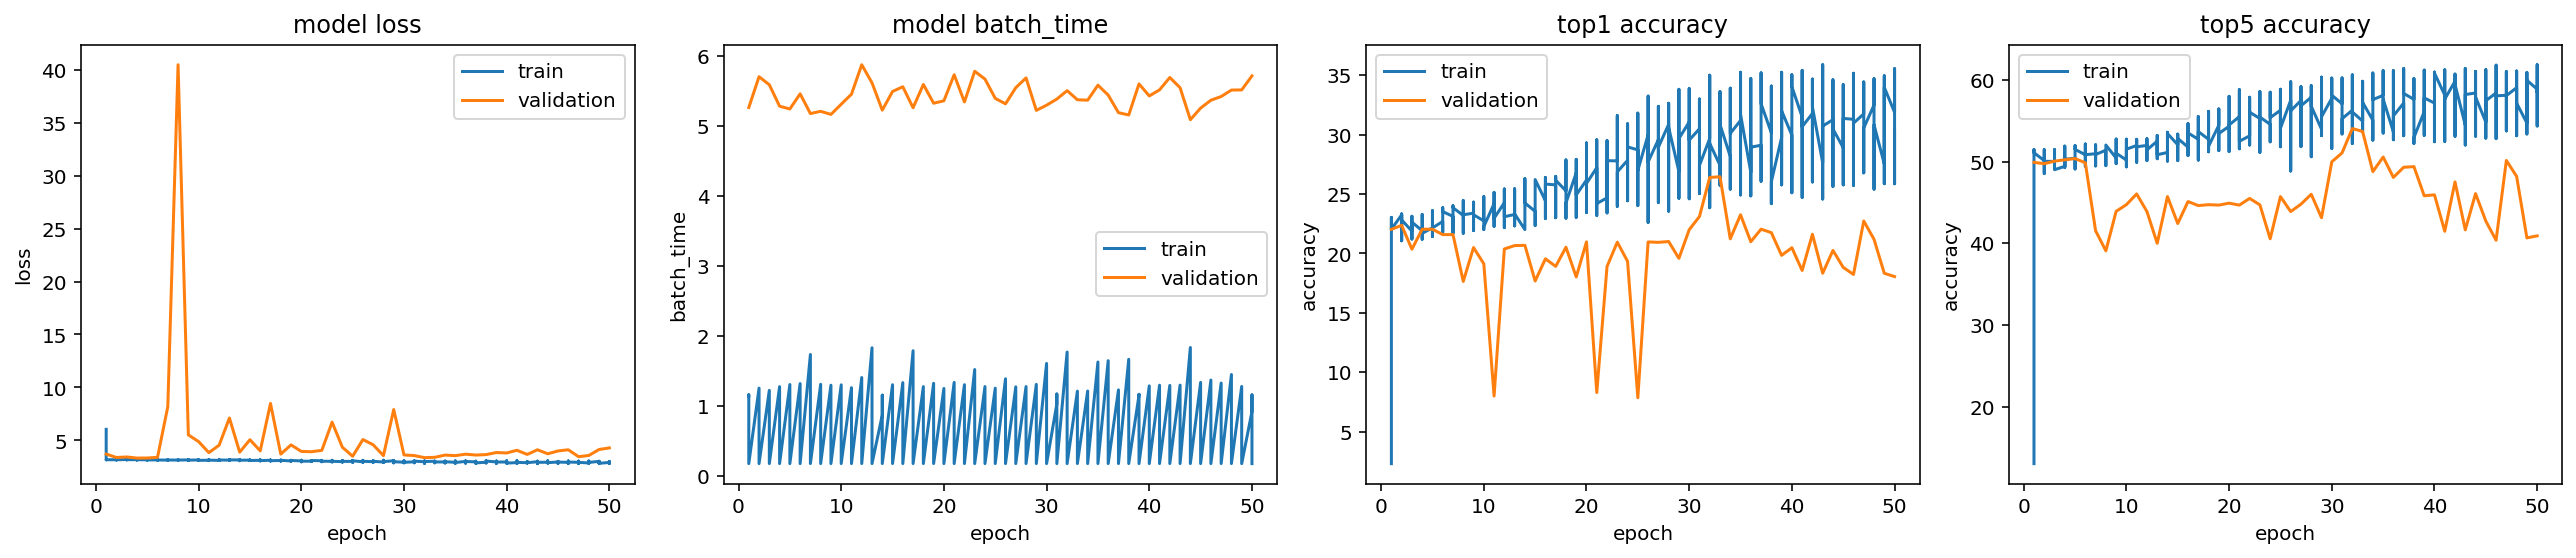

In [21]:
import matplotlib.pyplot as plt

def plot_training_curves(history): 
    
    fig, axes = plt.subplots(1, 4, figsize=(18, 4), sharex=True)
    
    ax = axes[0]
    ax.plot(history['epoch'], history['losses'], label='train')
    ax.plot(history['val_avg_epoch'], history['val_avg_losses'], label='validation')
    ax.set(
        title='model loss',
        ylabel='loss',
        xlabel='epoch')
    ax.legend()
    
    ax = axes[1]
    ax.plot(history['epoch'], history['batch_time'], label='train')
    ax.plot(history['val_avg_epoch'], history['val_avg_batch_time'], label='validation')
    ax.set(
        title='model batch_time',
        ylabel='batch_time',
        xlabel='epoch')
    ax.legend()
    
    
    ax = axes[2]
    ax.plot(history['epoch'], history['top1'], label='train')
    ax.plot(history['val_avg_epoch'], history['val_avg_top1'], label='validation')
    ax.set(
        title='top1 accuracy',
        ylabel='accuracy',
        xlabel='epoch')
    ax.legend()
    
    ax = axes[3]
    ax.plot(history['epoch'], history['top5'], label='train')
    ax.plot(history['val_avg_epoch'], history['val_avg_top5'], label='validation')
    ax.set(
        title='top5 accuracy',
        ylabel='accuracy',
        xlabel='epoch')
    ax.legend()
    fig.tight_layout()
    
plot_training_curves(model_history)

In [22]:
%store hyperparameters model_dir output_dir artifacts_dir

Stored 'hyperparameters' (dict)
Stored 'model_dir' (str)
Stored 'output_dir' (str)
Stored 'artifacts_dir' (str)


## 6. Check training results

import pandas as pd
pd.set_option('precision', 4)

df_stats = pd.DataFrame(data=training_stats)
df_stats = df_stats.set_index('epoch')
display(df_stats)

#model.load_state_dict(torch.load('./model.pt'))